 ----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
<h1><center>
    
Practical exam on Computer Vision: Part II
    
(January, 18th, 2024)
</center></h1>   

Consider the following:

- You can answer in English, Spanish or Catalan. 

- Add title to figures and add sufficient comments on the code to understand it.

- Make sure to print and plot exactly what it is indicated. If a reference image is provided, your output is expected to be exactly the same unless instructed differently. 

- At the end of the exam, upload only your .ipynb file (no need to upload the images)
    
- Make sure your code can be ran by us without errors.

- Use packages and solutions that were covered in your class and tutorials. If you are unsure about using a particular package, you should seek clarification from your instructor to confirm whether it is allowed.

- Please note that partial credit will be given based on the correctness of the code and the logic demonstrated. If certain parts of your code or answers are accurate, even if the final output is not entirely correct, you may still receive points.

----------------------------------------------------------------------------------------------------

In [99]:
from skimage import io
import matplotlib.pyplot as plt
from skimage.feature import plot_matches
from skimage import io, color, transform, img_as_float
from skimage.transform import resize
from skimage.feature import ORB, match_descriptors
from sklearn.decomposition import PCA
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from skimage.feature import hog
import matplotlib.patches as patches

## Exercise 1: Unveiling the Artistic Twins

We will analyze the similarity of Leonardo Da Vinci's Mona Lisa and Botero's reinterpretation of the piece of art. Here, you will leverage the knowledge gain in the course to see the correspondence between one painting to the other. 

### 1. (2 points) Correspondence between paintings

Detect correspondence between Leonardo Da Vinci's Mona Lisa and Botero's reinterpretation of it. 

Load the images `P2_MonaLisa.jpeg` and `P2_MonaLisa_Botero.jpeg` from the folder images. Use grayscale version of both and resize them to 300x250. 
In the parameters related to this algorithm, use:
- n_keypoints=500, max_ratio=0.9, cross_check=True

Plot the ORB results. It should be similar to this:
<img src = images/p2_monalisa_ORB.png width="300">


In [79]:
def to_grayscale(image):
    # Check if the image has 3 dimensions (row, column, channel)
    if len(image.shape) == 3:
        # Check if the image has 4 channels (RGBA)
        if image.shape[-1] == 4:
            # Convert RGBA to RGB
            image = color.rgba2rgb(image)
        # Now convert to grayscale
        return color.rgb2gray(image)
    # If the image is already 2D, return as is
    return image

In [87]:
def get_ORB(img1, img2, n_keypoints):
    """
    Extracts and matches ORB features between two images.
    Args:
        img1, img2: Input images.
        n_keypoints: Number of keypoints to detect.
    Returns:
        Tuple containing processed images, keypoints, and matches.
    """
    # Convert images to grayscale and normalize
    img1_gray = to_grayscale(img1)
    img2_gray = to_grayscale(img2)

    # Initialize ORB detector
    orb = ORB(n_keypoints=n_keypoints)

    # Detect and extract features from the first image
    orb.detect_and_extract(img1_gray)
    keypoints1 = orb.keypoints
    descriptors1 = orb.descriptors

    # Detect and extract features from the second image
    orb.detect_and_extract(img2_gray)
    keypoints2 = orb.keypoints
    descriptors2 = orb.descriptors

    # Match descriptors between images
    matches = match_descriptors(descriptors1, descriptors2, cross_check=True, max_ratio=1.0) #max ratio =  0.9

    return img1_gray, img2_gray, keypoints1, keypoints2, matches

C:\Users\adria\AppData\Local\Temp\ipykernel_17244\1881053770.py:19: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  plot_matches(ax, results[0], results[1], results[2], results[3], results[4])


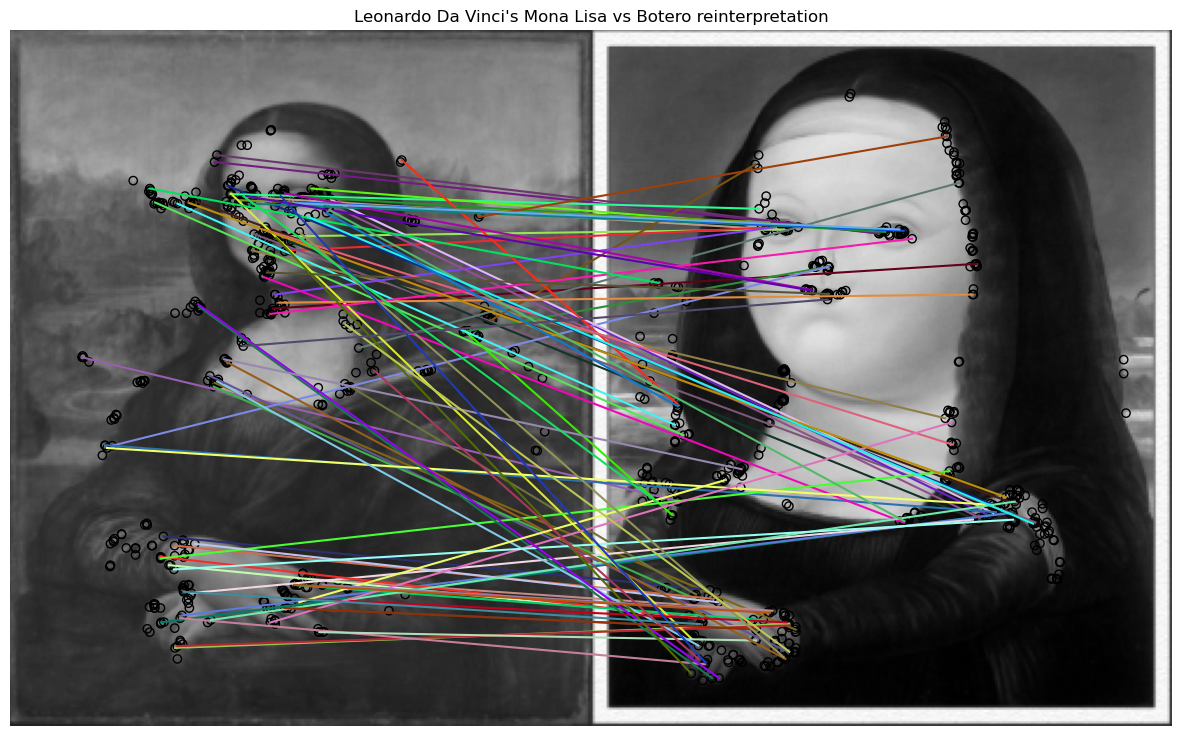

In [89]:
#Your solution here
monalisa = io.imread('./images/P2_MonaLisa.jpeg')
monalisa_Botero = io.imread('./images/P2_MonaLisa_Botero.jpeg')

#resize de las gray images
common_size = (300, 250)
monalisa_resized = transform.resize(monalisa, common_size, anti_aliasing=True)
monalisa_resized = (monalisa_resized * 255).astype(np.uint8)

monalisa_botero_resized = transform.resize(monalisa_Botero, common_size, anti_aliasing=True)
monalisa_botero_resized = (monalisa_botero_resized * 255).astype(np.uint8)

#Detect ORB features and matches
results = get_ORB(monalisa_resized, monalisa_botero_resized, 500)

#Plotting the matches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.set_title("Leonardo Da Vinci's Mona Lisa vs Botero reinterpretation")
plot_matches(ax, results[0], results[1], results[2], results[3], results[4])
ax.axis('off')
plt.show()

## Exercise 2: Car plate detection
Car plate detection is a very important task in computer vision given its applications. Apply what we have studied in class to create your first detector of EU car plates.

### 2. (2 points) Car plate detection with HOG

Today you are going to use HOG to build a detector for EU car plates. Part of the exploration process is to find the best reference image to build your HOG with, that is why in this exercise you will try 2 reference image to see how good it performs on a test image.   

Load `p2_matricula.jpeg` and `p2_matricula2.jpeg` from images folder, these are your reference images and `p2_matricula_ejemplo.jpeg` which is an image to test the detection algorithm you are going to develop. 

Take into consideration the following:
- Load the reference images: `p2_matricula.jpeg` and `p2_matricula2.jpeg` as **gray** scale and resize them to **25x50** 
- Get the HOG for both images, with **default** parameters. 
- Load `p2_matricula_ejemplo.jpeg` as **gray** scale and resize it to **45x75** 
- Use a sliding window of the size of the reference image to go across the test image calculating the hog and comparing it to the reference one. Do this for both reference images 
- Find the most similar Region of Interest based on **Norm 2 (np.linalg.norm function)** 
- Visualize the results by showing the hog of the reference image and then adding a red rectangle on the test image to show where highest similarity was found. Your results for both referencies should look as the following:
<img src = images/p2_HOG_result.png width="600">

**(This exercise could take up a few seconds running, however it should not take minutes)**

In [117]:
# Function to convert any image to grayscale, handling alpha channel if present
def to_grayscale(image):
    # Check if the image has 3 dimensions (row, column, channel)
    if len(image.shape) == 3:
        # Check if the image has 4 channels (RGBA)
        if image.shape[-1] == 4:
            # Convert RGBA to RGB
            image = color.rgba2rgb(image)
        # Now convert to grayscale
        return color.rgb2gray(image)
    # If the image is already 2D, return as is
    return image

In [119]:
# Auxiliary function to display a set of images with titles
def showImage(figsize, images, titles, cmap='gray', show_axis=False):
    if len(images) != len(titles):
        raise ValueError("The number of images and titles must be the same.")
    
    # Calculate the number of rows needed for 3 images per row
    n_rows = int(np.ceil(len(images) / 3))
    fig = plt.figure(figsize=figsize)

    for index, image in enumerate(images):
        # Calculate the appropriate row and column for each image
        row = index // 3 + 1
        col = index % 3 + 1
        ax = fig.add_subplot(n_rows, 3, index + 1)
        ax.set_title(titles[index])
        ax.imshow(image, cmap=cmap)
        if not show_axis:
            ax.axis('off')
    plt.show()

In [121]:
def getHOG(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), channel_axis=None):
    img_gray_f = img_as_float(image)

    if channel_axis is not None:
        fd, hog_image = hog(img_gray_f, orientations=orientations, pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, visualize=True, channel_axis=channel_axis)
    else:
        fd, hog_image = hog(img_gray_f, orientations=orientations, pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, visualize=True)
    return hog_image

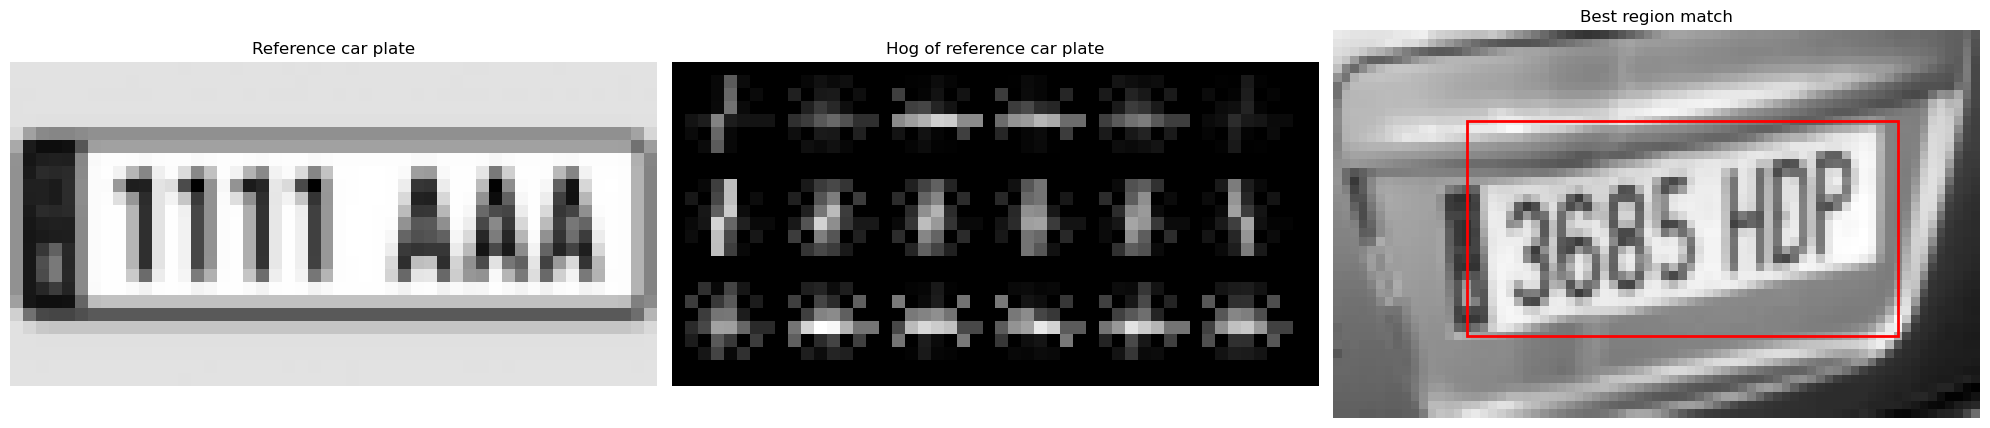

In [127]:
# Your solution here
matricula = io.imread('./images/p2_matricula.jpeg')
matricula_gray = to_grayscale(matricula)

matricula2 = io.imread('./images/p2_matricula2.jpeg')
matricula2_gray = to_grayscale(matricula2)

matricula_ejemplo = io.imread('./images/p2_matricula_ejemplo.jpeg')
matricula_ejemplo_gray = to_grayscale(matricula_ejemplo)

# Resize de las imágenes en escala de grises
common_size = (25, 50)
matricula_resized = transform.resize(matricula_gray, common_size, anti_aliasing=True)
matricula_resized = (matricula_resized * 255).astype(np.uint8)

matricula2_resized = transform.resize(matricula2_gray, common_size, anti_aliasing=True)
matricula2_resized = (matricula2_resized * 255).astype(np.uint8)

common_size_ejemplo = (45, 75)
matricula_ejemplo_resized = transform.resize(matricula_ejemplo_gray, common_size_ejemplo, anti_aliasing=True)
matricula_ejemplo_resized = (matricula_ejemplo_resized * 255).astype(np.uint8)

# Hacer HOG
hog_matricula2 = getHOG(matricula2_resized)  # HOG de la referencia matricula2

# Función para encontrar la mejor región
def find_best_match(template, image, step=5):
    """
    Encuentra la región más similar en la imagen utilizando deslizamiento de ventana y comparación de HOG.
    """
    from queue import PriorityQueue
    pq = PriorityQueue()
    template_hog = getHOG(template)

    # Sliding window
    for y in range(0, image.shape[0] - template.shape[0] + 1, step):
        for x in range(0, image.shape[1] - template.shape[1] + 1, step):
            window = image[y:y + template.shape[0], x:x + template.shape[1]]
            window_hog = getHOG(window)
            distance = np.linalg.norm(window_hog - template_hog)
            pq.put((distance, (x, y)))

    # Retorna la mejor coincidencia (coordenadas y distancia mínima)
    _, best_coords = pq.get()
    return best_coords

# Encontrar la mejor región
best_coords = find_best_match(matricula_resized, matricula_ejemplo_resized)

# Visualizar las imágenes con el rectángulo rojo
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(matricula_resized, cmap='gray')
axes[0].set_title('Reference car plate')
axes[0].axis('off')

axes[1].imshow(hog_matricula2, cmap='gray')
axes[1].set_title('Hog of reference car plate')
axes[1].axis('off')

axes[2].imshow(matricula_ejemplo_resized, cmap='gray')
x, y = best_coords
rect = patches.Rectangle((x, y), common_size[1], common_size[0], edgecolor='r', facecolor='none', linewidth=2)
axes[2].add_patch(rect)
axes[2].set_title('Best region match')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Exercise 3: Is it a Chihuahua or a muffin? 
Sometimes things that seem simple to discern from can be extremely complicated from a computer vision standpoint. A curious example of this is the similarity of a blonde chihuahua and a blueberry muffin. Let's explore how to create a classifier to distinguish between them.  

### 3. (3 points) Chihuahua vs muffin - PCA features

We would like to build a model to classify between confusing images of chihuahuas and muffins. For this you will leverage PCA features studied in this course. 

### 3.1 (1 point) First build two datasets X_train with some of the images in `images/ChihuahuaVsMuffin` and X_test with remaining images. 

The split of files are the following:

```python
# Train files
training_files = ["chihuahua_1", "chihuahua_2", "chihuahua_3", "chihuahua_4", "chihuahua_5",
                  "chihuahua_6", "chihuahua_7", "chihuahua_8", "chihuahua_9", "chihuahua_10",
                  "muffin_1", "muffin_2", "muffin_3", "muffin_4", "muffin_5",
                  "muffin_6", "muffin_7", "muffin_8", "muffin_9", "muffin_10"]
# Test files
test_files = ["chihuahua_test", "muffin_test"]
```

- Make sure to load the images as **gray scale** and resize them to **300x250 pixels**. Also create **y_train** and **y_test** with the corresponding label (chihuahua or muffin, you can deduce it based on the image name), these objects would be used in exercise 4. (*Note: The model will understand if your labels are "muffin" and "chihuahua" but you can also define them by a numerical value representation with chihuahua being 1 and muffin as 0, as you did in the labs.*) 

- Dataset should be of size **X_train:(20, 300, 250)** and **X_test:(2, 300, 250)**. Your *Ys* must be of length **20 and 2** respectively. 


Show one chihuahua and one muffin of the arrays loaded in a 1x2 grid just as below (make sure your titles are the corresponding **y** labels): 
<img src = images/p2_chihuahuavsmuffin.png width="500">


In [35]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.color import rgba2rgb
from skimage.transform import resize

# Paths
# Paths
image_dir = './images/ChihuahuaVsMuffin'  # Correct usage: just a string path


# Train and test file names
training_files = [
    "chihuahua_1", "chihuahua_2", "chihuahua_3", "chihuahua_4", "chihuahua_5",
    "chihuahua_6", "chihuahua_7", "chihuahua_8", "chihuahua_9", "chihuahua_10",
    "muffin_1", "muffin_2", "muffin_3", "muffin_4", "muffin_5",
    "muffin_6", "muffin_7", "muffin_8", "muffin_9", "muffin_10"
]
test_files = ["chihuahua_test", "muffin_test"]

# Image dimensions
img_height, img_width = 300, 250

# Helper function to load, preprocess, and resize images
def load_and_preprocess_images(file_list, label_mapping):
    """
    Load and preprocess images for training and testing.
    - Convert images to grayscale.
    - Resize images to the specified dimensions.

    Parameters:
    - file_list: List of file names to load.
    - label_mapping: Dictionary mapping labels to numerical values.

    Returns:
    - X: Array of processed images.
    - y: Array of labels corresponding to the images.
    """
    X = []
    y = []
    for file_name in file_list:
        file_path = os.path.join(image_dir, file_name + ".png")
        image = imread(file_path)
        if image.shape[-1] == 4:  # Convert RGBA to RGB if needed
            image = rgba2rgb(image)
        gray_image = rgb2gray(image)
        resized_image = resize(gray_image, (img_height, img_width), anti_aliasing=True)
        X.append(resized_image)
        label = label_mapping[file_name.split("_")[0]]
        y.append(label)
    return np.array(X), np.array(y)

# Define label mapping
label_mapping = {"chihuahua": 1, "muffin": 0}

# Load training and test datasets
X_train, y_train = load_and_preprocess_images(training_files, label_mapping)
X_test, y_test = load_and_preprocess_images(test_files, label_mapping)

# Verify dataset shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (20, 300, 250), y_train shape: (20,)
X_test shape: (2, 300, 250), y_test shape: (2,)


### 3.2 (1 point) Once you have your dataset loaded in the right format, perform a PCA of 20 components.

- Make sure the input you put into the PCA is of size (20, 75000) 


In [41]:
#Your solution here
from sklearn.decomposition import PCA

# Flatten the training dataset to shape (20, 75000)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flattened training set

# Perform PCA with 20 components
n_components = 20
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_flat)

# Print the resulting shape of the PCA-transformed data
print(f"Shape of PCA-transformed data: {X_train_pca.shape}")

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by {n_components} components: {np.sum(explained_variance):.2f}")

Shape of PCA-transformed data: (20, 20)
Explained variance by 20 components: 1.00


### 3.3 (1 point) Visualize the first 15 components

Your results should look as follows:
<img src = images/p2_eigenvalues.png width="800">


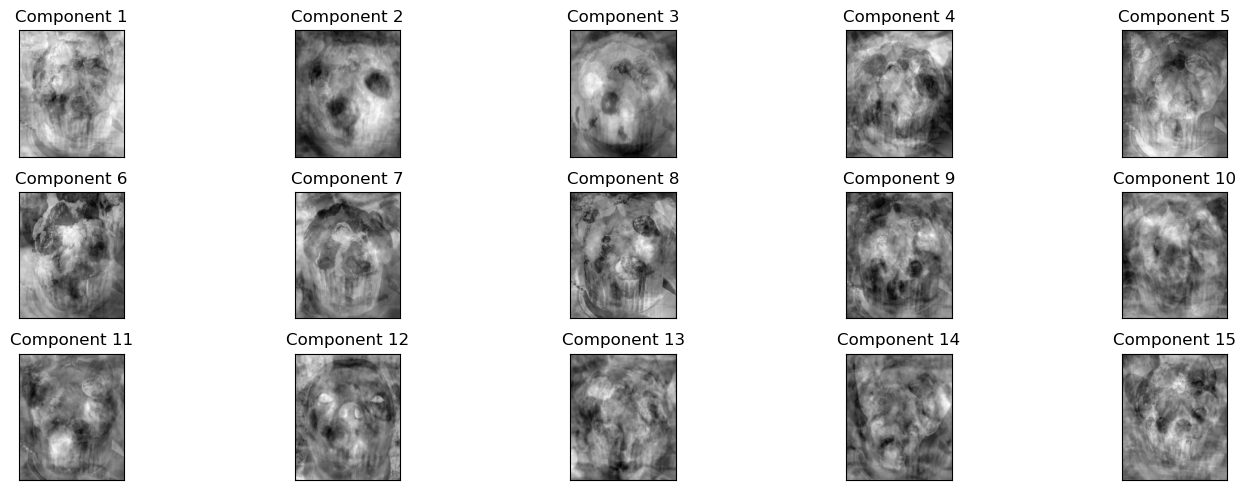

In [55]:
#Your solution here
principal_components = pca.components_

principal_components = principal_components[:15]
# Reshape each principal component into the original image dimensions
principal_components = [component.reshape((img_height, img_width)) for component in principal_components]

fig = plt.figure(figsize=(15, 5))

for i, component in enumerate(principal_components):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.set_title(f'Component {i + 1}')
    ax.imshow(component,cmap='gray')
plt.tight_layout()
plt.show()

## Exercise 4:  Classification of chihuahua vs muffin

## 4. (3 points) Classification with Adaboost

From the PCA performed in exercise 3, save as your X_train and X_test the respective **first 15 components**. Once you have the 15 components with highest variance explained extracted from each image, build with them an Adaboost model with **25 estimators** with the train dataset.You need to show:
1. The training set accuracy *(percentage of correctly classified images)*
2. The testing set accuracy

In [59]:
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Flatten the datasets
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (20, 75000)
X_test_flat = X_test.reshape(X_test.shape[0], -1)    # Shape: (2, 75000)

# Apply PCA
n_components = 15
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_flat)  # Transform training set
X_test_pca = pca.transform(X_test_flat)       # Transform testing set

# Classification with Adaboost
X_train_15 = X_train_pca  # Already reduced to 15 components
X_test_15 = X_test_pca    # Already reduced to 15 components

# Create the Adaboost model
adaboost_model = AdaBoostClassifier(n_estimators=25, random_state=42)

# Train the model
adaboost_model.fit(X_train_15, y_train)

# Predictions
y_train_pred = adaboost_model.predict(X_train_15)
y_test_pred = adaboost_model.predict(X_test_15)

# Compute accuracies
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

# Print results
print(f"Training set accuracy: {train_accuracy:.2f}%")
print(f"Testing set accuracy: {test_accuracy:.2f}%")


Training set accuracy: 100.00%
Testing set accuracy: 50.00%


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Answer the following:
- Mention one advantage of using PCA to extract features vs using the original array (i.e. the image). 

PCA reduces the dimensionality of the data, making models faster to train and less prone to overfitting by removing noise and redundancy. It retains only the most significant features, improving computational efficiency and generalization.